<a href="https://colab.research.google.com/github/thejj-theju/Brain-Tumor-Detector/blob/main/Brain_tumer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor MRI Image Classification** --CNN

Steps Includes:

 Importing Lib -> Mount drive -> data prepocessing(augumentation) ->Built Custom Model -> using transfer Learning -> saving Model.








## **Importing Neccessary Libraries**

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Mouting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
test_dir='/content/drive/MyDrive/Tumour/test'
train_dir='/content/drive/MyDrive/Tumour/train'
val_dir='/content/drive/MyDrive/Tumour/valid'

In [ ]:
test_dir

In [ ]:
#Running this to verify folders exist:

import os

print("Train folders:", os.listdir('/content/drive/MyDrive/Tumour/train'))
print("Valid folders:", os.listdir('/content/drive/MyDrive/Tumour/valid'))
print("Test folders:", os.listdir('/content/drive/MyDrive/Tumour/test'))


Train folders: ['_classes.csv', 'glioma', 'meningioma', 'no_tumor', 'pituitary']
Valid folders: ['_classes.csv', 'glioma', 'meningioma', 'pituitary', 'no_tumor']
Test folders: ['_classes.csv', 'glioma', 'meningioma', 'pituitary', 'no_tumor']


# Validate the Class Balance

In [ ]:
import os
from PIL import Image
from collections import defaultdict

base = "/content/drive/MyDrive/Tumour"

splits = ["train", "valid", "test"]

print("-----Dataset summary----")
for s in splits:
    split_path = os.path.join(base, s)
    if not os.path.isdir(split_path):
        continue

    print(f"\n>> {s.upper()}")
    class_dirs = [d for d in os.listdir(split_path)
                  if os.path.isdir(os.path.join(split_path, d))]
    counts = {}
    for cls in class_dirs:
        cls_path = os.path.join(split_path, cls)
        imgs = [f for f in os.listdir(cls_path)
                if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]
        counts[cls] = len(imgs)
    print("Image count per class:", counts)


-----Dataset summary----

>> TRAIN
Image count per class: {'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}

>> VALID
Image count per class: {'glioma': 161, 'meningioma': 124, 'pituitary': 118, 'no_tumor': 99}

>> TEST
Image count per class: {'glioma': 80, 'meningioma': 63, 'pituitary': 54, 'no_tumor': 49}


## **Data Preprocessing + Data Augumentation**

##Data augmentation:

Artificially modifying your images in various ways (rotation, flipping, zooming, brightness/contrast change, shifting, etc.) to generate new variants for training

In [ ]:
#Train data generator with augmentation  # rgb-0-255 ->256
train_datagen=ImageDataGenerator(
    rescale=1./255.0,    # normalize pixels to [0,1]

    #  augmentation parameters
    rotation_range=20,    # randomly rotate images by upto 20 degree
    width_shift_range=0.1,  # randomly shift the width(horizontal shift)
    height_shift_range=0.1,  # randomly shift the height(vertical shift)
    zoom_range=0.1,           # randomly zoom image
    horizontal_flip=True,    # Flip image horizontally,-->like mirror image
    vertical_flip=False,      # (optional here) no need in medical images
    brightness_range=[0.8,1.2],  # randomlly change brightness- useful if images vary in intensity
    fill_mode='nearest'       # fills newly created pixels,--fill_mode defines how to fill in new pixels that appear when an image is transformed (rotated, shifted, zoomed, etc.),
                                # fill mode can be (nearest,constant--consstant color like black, reflect, wrap)

)


# validation and test Generatores (here only rescaling , with no augmentation)

val_datagen= ImageDataGenerator(rescale = 1./255.0)
test_datagen= ImageDataGenerator( rescale=1./255.0)



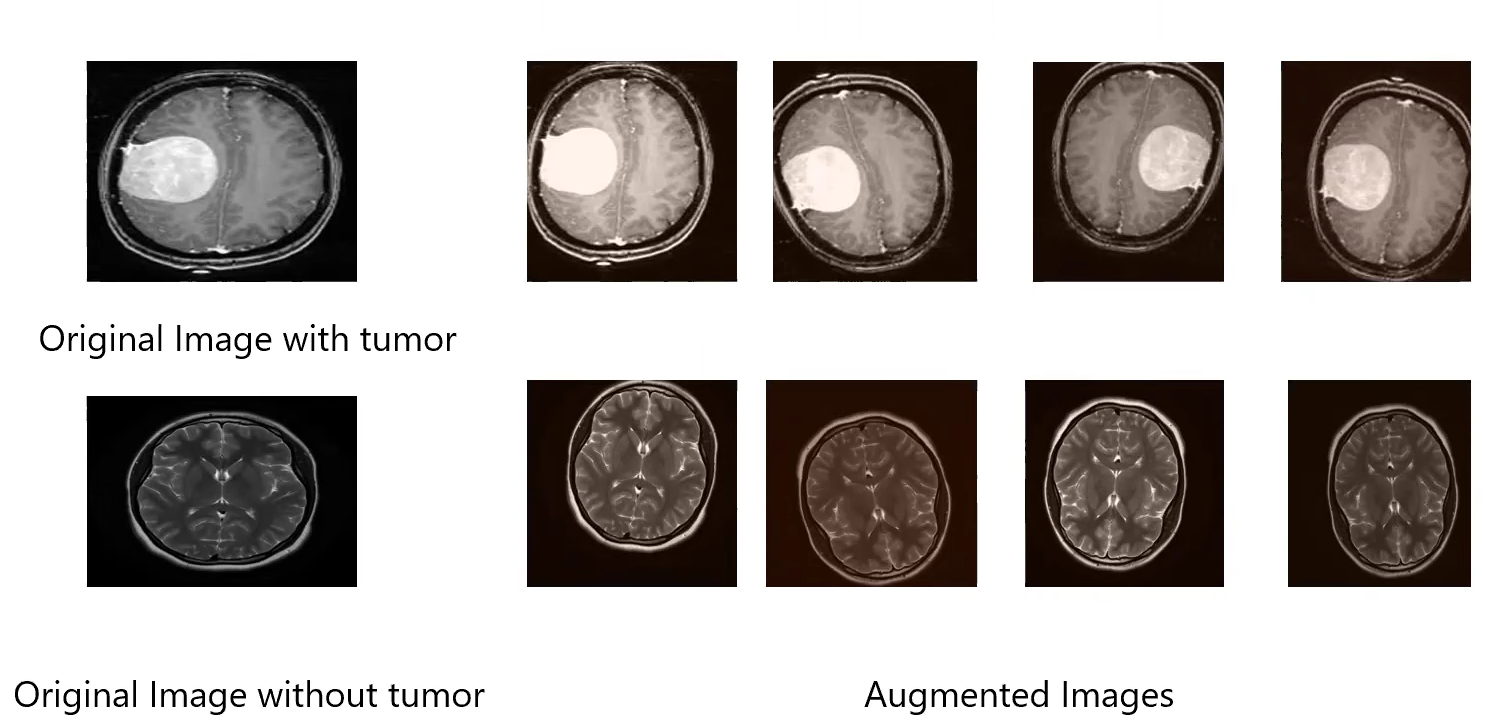

## **Applying Data augmentation with original Imges**

using (flow_from_directory) is where we are connecting our data-augmentation /

preprocessing pipeline to our actual image files





---








In [ ]:

# Setting image size and batch size
img_width, img_height = 224, 224  # 224 is standard in DL, change it if needed
batch_size =40  # batch size

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  #  'categorical' for multi-class or 'binary' for for 2 class
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# **Class indices**

In [ ]:

train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

In [ ]:

test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

Note:When you call flow_from_directory(directory), Keras looks at the sub-folder names under directory.

1.   Each sub-folder is treated as a separate class, unless you manually specify a classes=list.
2.   Keras sorts those folder names alphabetically, then assigns indices 0, 1, 2… in that order, to classes.


In [ ]:

class_names = list(train_generator.class_indices.keys())
class_names

['glioma', 'meningioma', 'no_tumor', 'pituitary']

In [ ]:
num_classes = len(train_generator.class_indices)
num_classes

4

# **Custom Model Building**

In [ ]:
model= models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dropout(0.5),

    # Bigger Dense layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(22, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # binary-->binary cross entropy
    metrics=['accuracy','recall', 'precision']  # F1 score
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 22)             │         2,838 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,172,072 (42.62 MB)

 Trainable params: 11,172,072 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

# **Train my custom Model**

when I pass validation_data to fit() so that during training, after each epoch, Keras automatically tests the model.


*  giving  how well the model generalizes (not just memorizes).

*   This helps you detect overfitting, adjust hyperparameters/architecture, and pick a good model before final testing.



In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 957ms/step - accuracy: 0.2339 - loss: 1.4399 - precision: 0.1890 - recall: 0.0128 - val_accuracy: 0.4761 - val_loss: 1.2516 - val_precision: 1.0000 - val_recall: 0.0060
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 786ms/step - accuracy: 0.4088 - loss: 1.2685 - precision: 0.4641 - recall: 0.0504 - val_accuracy: 0.6235 - val_loss: 1.0528 - val_precision: 0.7448 - val_recall: 0.2849
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 761ms/step - accuracy: 0.4973 - loss: 1.1432 - precision: 0.6478 - recall: 0.2168 - val_accuracy: 0.5677 - val_loss: 0.9409 - val_precision: 0.8068 - val_recall: 0.3327
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 782ms/step - accuracy: 0.5603 - loss: 1.0580 - precision: 0.6518 - recall: 0.2740 - val_accuracy: 0.6494 - val_loss: 0.8730 - val_precision: 0.8282 - val_recall: 0.3745
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 748ms/step - accuracy: 0.5802 - loss: 1.0283 - precision: 0.6986 - recall: 0.2854 - val_accuracy: 0.6494 - val_los

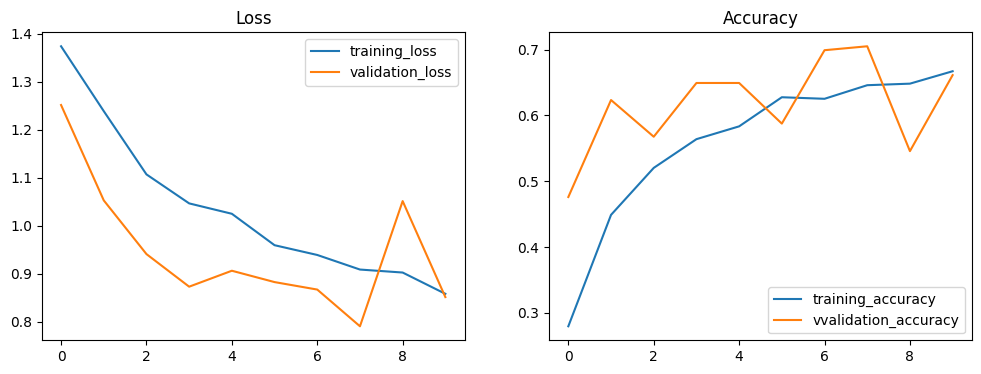

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='vvalidation_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()



In [ ]:
# Evaluate on validation (or a separate test) set
val_loss, val_acc, val_precision, val_recall= model.evaluate(validation_generator)
print("Validation loss:", val_loss, "Validation accuracy:", val_acc)


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7111 - loss: 0.6842 - precision: 0.7492 - recall: 0.6160
Validation loss: 0.6919007897377014 Validation accuracy: 0.6972111463546753


In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')
print(f'Test Loss:, {test_loss:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.7003 - loss: 0.8549 - precision: 0.8179 - recall: 0.5169

Test accuracy: 0.6789
Test precision: 0.5000
Test recall: 0.8039
Test Loss:, 0.8637


# Saving custom Model

In [ ]:

model.save('/content/drive/MyDrive/model.h5')

In [ ]:
test_generator.reset() #generator will start from the first image
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step


In [ ]:
predictions[0]

In [ ]:
predicted_classes

array([0, 0, 0, 3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1,
       3, 0, 2, 1, 0, 0, 1, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 3, 0, 3, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 1, 3, 1, 1, 1,
       1, 1, 2, 1, 3, 3, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3,
       2, 3, 3, 3])

In [ ]:

true_classes = test_generator.classes

In [ ]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3], dtype=int32)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(cm)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.82      0.84        80
  meningioma       0.83      0.30      0.44        63
    no_tumor       0.49      0.90      0.64        49
   pituitary       0.68      0.70      0.69        54

    accuracy                           0.68       246
   macro avg       0.71      0.68      0.65       246
weighted avg       0.73      0.68      0.66       246

Confusion Matrix:
[[66  4  7  3]
 [11 19 23 10]
 [ 0  0 44  5]
 [ 1  0 15 38]]


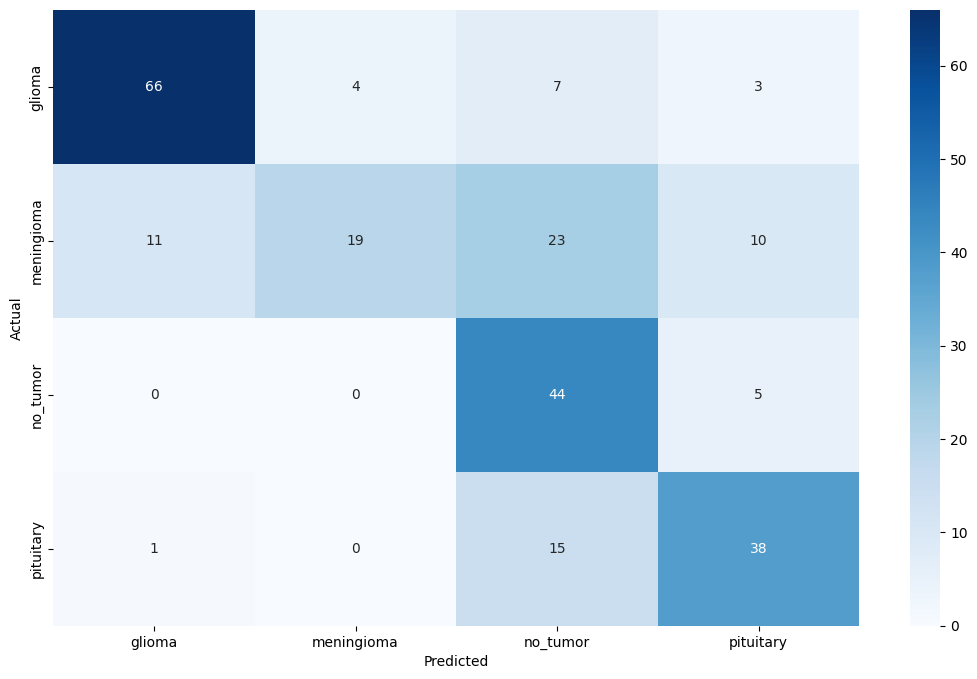

In [ ]:
import seaborn as sns
plt.figure(figsize=(13,8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# always in confusion matrix -->if confusion_matrix(actual, predict)--> then  rows = actual, columns = predicted.

# **Transfer Learning**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2,InceptionV3,EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
evaluate = []

# **1. VGG16**

In [ ]:
#Building the transfer-learning model

base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_width, img_height, 3))

# Freeze base model layers — we don’t want to re-train them initially

base_model.trainable = False

model_vgg = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),    # or we can use Flatten()
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','recall', 'precision']
)

history = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 694s 16s/step - accuracy: 0.2971 - loss: 1.6535 - precision: 0.3045 - recall: 0.1368 - val_accuracy: 0.5876 - val_loss: 1.1562 - val_precision: 0.9592 - val_recall: 0.0936
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 831ms/step - accuracy: 0.4527 - loss: 1.2659 - precision: 0.5677 - recall: 0.1885 - val_accuracy: 0.5697 - val_loss: 1.0776 - val_precision: 0.8936 - val_recall: 0.1673
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 809ms/step - accuracy: 0.5093 - loss: 1.1171 - precision: 0.6769 - recall: 0.2437 - val_accuracy: 0.6813 - val_loss: 0.9671 - val_precision: 0.8079 - val_recall: 0.2430
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 791ms/step - accuracy: 0.5531 - loss: 1.0350 - precision: 0.7106 - recall: 0.3472 - val_accuracy: 0.6713 - val_loss: 0.8955 - val_precision: 0.8282 - val_recall: 0.3745
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 832ms/step - accuracy: 0.6030 - loss: 0.9646 - precision: 0.7237 - recall: 0.4020 - val_accuracy: 0.6633 - val_loss

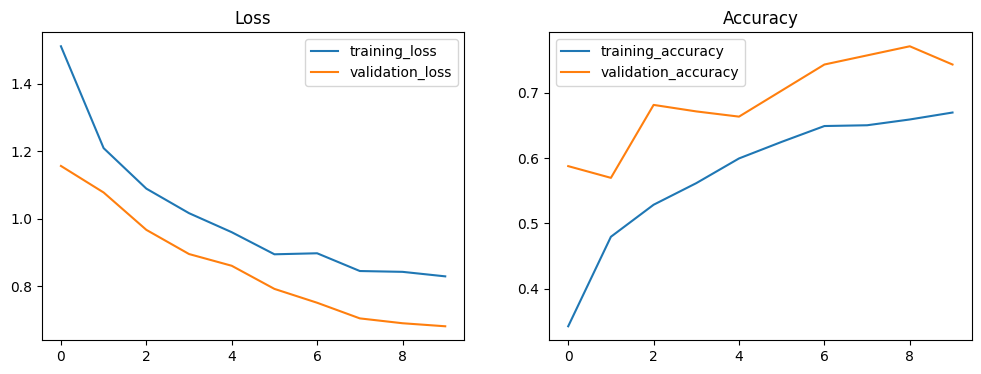

In [ ]:
plt.figure(figsize=(12,4))



plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [ ]:
test_loss_vgg, test_acc_vgg, test_precision_vgg, test_recall_vgg = model_vgg.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc_vgg:.4f}')
print(f'Test precision: {test_precision_vgg:.4f}')
print(f'Test recall: {test_recall_vgg:.4f}')
print(f'Test Loss:, {test_loss_vgg:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 11s/step - accuracy: 0.7736 - loss: 0.6166 - precision: 0.9040 - recall: 0.6270

Test accuracy: 0.7602
Test precision: 0.5894
Test recall: 0.8951
Test Loss:, 0.6765


In [ ]:
#model_vgg.save('/content/drive/MyDrive/model_vgg.h5')

# **2. ResNet50**

In [ ]:
base_mdoel = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_width, img_height,3))

# Freeze base model layers — we don’t want to re-train them initially
base_model.trainable=False

model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(120, activation ='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')

])

model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy','precision','recall'])


history_resent= model_resnet.fit(train_generator,
                                 epochs=10,
                                 validation_data=validation_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 932ms/step - accuracy: 0.2951 - loss: 1.6252 - precision: 0.3119 - recall: 0.1256 - val_accuracy: 0.4900 - val_loss: 1.2114 - val_precision: 0.7840 - val_recall: 0.1952
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 923ms/step - accuracy: 0.4651 - loss: 1.2297 - precision: 0.6284 - recall: 0.2073 - val_accuracy: 0.6016 - val_loss: 1.0832 - val_precision: 0.7687 - val_recall: 0.2052
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 821ms/step - accuracy: 0.5145 - loss: 1.1480 - precision: 0.6721 - recall: 0.2690 - val_accuracy: 0.6753 - val_loss: 0.9656 - val_precision: 0.7806 - val_recall: 0.2410
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 792ms/step - accuracy: 0.5515 - loss: 1.0532 - precision: 0.7122 - recall: 0.3481 - val_accuracy: 0.6793 - val_loss: 0.9074 - val_precision: 0.8017 - val_recall: 0.3705
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 822ms/step - accuracy: 0.6110 - loss: 0.9592 - precision: 0.737

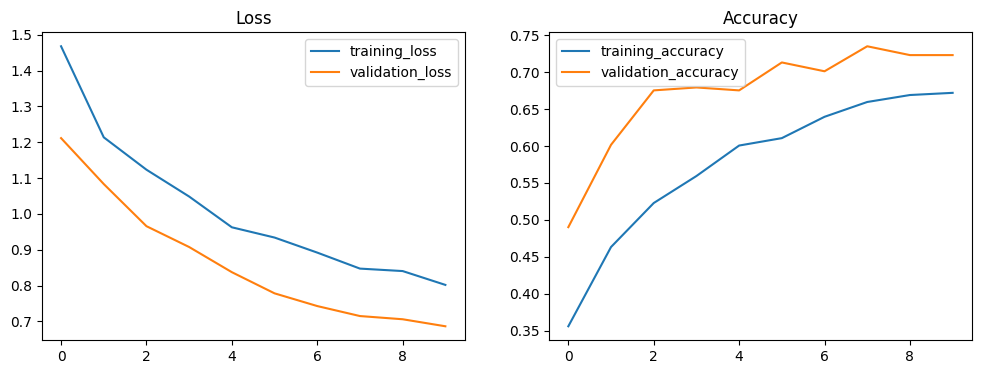

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_resent.history['loss'], label='training_loss')
plt.plot(history_resent.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history_resent.history['accuracy'], label='training_accuracy')
plt.plot(history_resent.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
test_loss_resnet, test_acc_resnet, test_precision_resnet, test_recall_resnet = model_resnet.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc_resnet:.4f}')
print(f'Test precision: {test_precision_resnet:.4f}')
print(f'Test recall: {test_recall_resnet:.4f}')
print(f'Test Loss:, {test_loss_resnet:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.7431 - loss: 0.6358 - precision: 0.8406 - recall: 0.6312

Test accuracy: 0.7358
Test precision: 0.8232
Test recall: 0.6057
Test Loss:, 0.6912


# **3. MobileNetV2**

In [ ]:

base_model = MobileNetV2(weights='imagenet', include_top=False,
                       input_shape=(img_width, img_height, 3))

base_model.trainable = False

#  model = tf.keras.Sequential([
#         base_model,
#         GlobalAveragePooling2D(),
#         Dropout(0.2),
#         Dense(num_classes, activation='softmax')

model_mob = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(120, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_mob.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

history_mob = model_mob.fit(train_generator,
                            epochs=10,
                            validation_data=validation_generator)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4359 - loss: 1.3749 - precision: 0.5438 - recall: 0.2221 - val_accuracy: 0.7331 - val_loss: 0.7186 - val_precision: 0.8058 - val_recall: 0.6116
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 776ms/step - accuracy: 0.7260 - loss: 0.6968 - precision: 0.7999 - recall: 0.6186 - val_accuracy: 0.7570 - val_loss: 0.6229 - val_precision: 0.8145 - val_recall: 0.7171
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 780ms/step - accuracy: 0.7747 - loss: 0.5807 - precision: 0.8138 - recall: 0.7214 - val_accuracy: 0.7869 - val_loss: 0.5752 - val_precision: 0.8122 - val_recall: 0.7669
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 802ms/step - accuracy: 0.8147 - loss: 0.5188 - precision: 0.8442 - recall: 0.7725 - val_accuracy: 0.8048 - val_loss: 0.4865 - val_precision: 0.8395 - val_recall: 0.7709
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 743ms/step - accuracy: 0.8415 - loss: 0.4464 - precision: 0.8682 - r

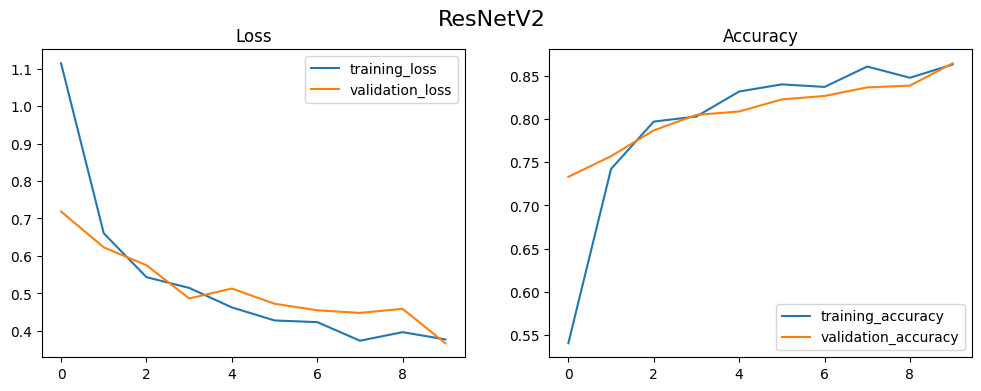

In [ ]:
plt.figure(figsize=(12,4))
plt.suptitle("ResNetV2", fontsize=16)
plt.subplot(1,2,1)
plt.plot(history_mob.history['loss'], label='training_loss')
plt.plot(history_mob.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history_mob.history['accuracy'], label='training_accuracy')
plt.plot(history_mob.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
model_mob.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,510,574 (9.58 MB)

 Trainable params: 84,196 (328.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 168,394 (657.79 KB)

In [ ]:
val_loss_mob, val_acc_mob, val_precision_mob, val_recall_mob = model_mob.evaluate(validation_generator)
print(f'\nTest accuracy: {val_acc_mob:.4f}')
print(f'Test precision: {val_precision_mob:.4f}')
print(f'Test recall: {val_recall_mob:.4f}')
print(f'Test Loss:, {val_loss_mob:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.8747 - loss: 0.3425 - precision: 0.8869 - recall: 0.8582

Test accuracy: 0.8645
Test precision: 0.8753
Test recall: 0.8386
Test Loss:, 0.3670


In [ ]:
test_loss_mob, test_acc_mob, test_precision_mob, test_recall_mob = model_mob.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc_mob:.4f}')
print(f'Test precision: {test_precision_mob:.4f}')
print(f'Test recall: {test_recall_mob:.4f}')
print(f'Test Loss:, {test_loss_mob:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8463 - loss: 0.4176 - precision: 0.8768 - recall: 0.8281

Test accuracy: 0.8496
Test precision: 0.8766
Test recall: 0.8374
Test Loss:, 0.4075


Saving Mobile net model

In [ ]:

#model_mob.save('/content/drive/MyDrive/model_mob.h5')

In [ ]:
model_mob.save('/content/drive/MyDrive/model_mob.keras')

# **4. InceptionV3**


In [ ]:
# Note: if InceptionV3 expects different image size, ensure img_width/img_height accordingly
base_model = InceptionV3(weights='imagenet', include_top=False,
                       input_shape=(img_width, img_height, 3))

base_model.trainable = False

model_inc = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_inc.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

history_inc = model_inc.fit(train_generator,
                            epochs=10,
                            validation_data=validation_generator)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4492 - loss: 1.4853 - precision: 0.5110 - recall: 0.3499 - val_accuracy: 0.7291 - val_loss: 0.7161 - val_precision: 0.8580 - val_recall: 0.5777
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 804ms/step - accuracy: 0.6772 - loss: 0.7782 - precision: 0.7758 - recall: 0.5994 - val_accuracy: 0.7490 - val_loss: 0.6134 - val_precision: 0.8019 - val_recall: 0.6773
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 771ms/step - accuracy: 0.7299 - loss: 0.7348 - precision: 0.7777 - recall: 0.6477 - val_accuracy: 0.8127 - val_loss: 0.5268 - val_precision: 0.8612 - val_recall: 0.7291
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 790ms/step - accuracy: 0.7512 - loss: 0.6670 - precision: 0.8209 - recall: 0.6988 - val_accuracy: 0.8207 - val_loss: 0.4853 - val_precision: 0.8818 - val_recall: 0.7729
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 772ms/step - accuracy: 0.7541 - loss: 0.6039 - precision: 0.7963 -

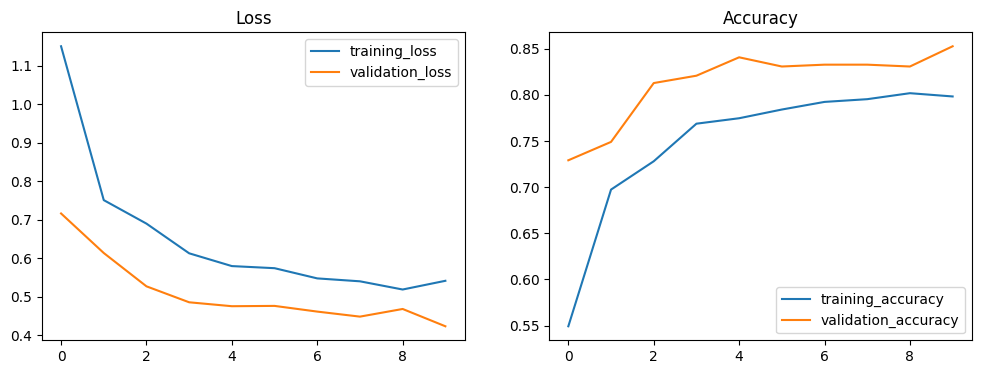

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_inc.history['loss'], label='training_loss')
plt.plot(history_inc.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history_inc.history['accuracy'], label='training_accuracy')
plt.plot(history_inc.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
test_loss_inc, test_acc_inc, test_precision_inc, test_recall_inc = model_inc.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc_inc:.4f}')
print(f'Test precision: {test_precision_inc:.4f}')
print(f'Test recall: {test_recall_inc:.4f}')
print(f'Test Loss:, {test_loss_inc:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8146 - loss: 0.4388 - precision: 0.8587 - recall: 0.7696

Test accuracy: 0.8211
Test precision: 0.8597
Test recall: 0.7724
Test Loss:, 0.4607


In [ ]:
model_inc.save('/content/drive/MyDrive/model_inc.h5')

# **5. EfficientNetB0**

In [ ]:

base_model = EfficientNetB0(weights='imagenet', include_top=False,
                          input_shape=(img_width, img_height, 3))
base_model.trainable = False

model_eff = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])
model_eff.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

history_eff = model_eff.fit(train_generator,
                            epochs=10,
                            validation_data=validation_generator)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.3294 - loss: 1.3833 - precision: 0.0718 - recall: 4.2155e-04 - val_accuracy: 0.3207 - val_loss: 1.3873 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 775ms/step - accuracy: 0.2991 - loss: 1.3816 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3207 - val_loss: 1.3825 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 756ms/step - accuracy: 0.2968 - loss: 1.3825 - precision: 0.0436 - recall: 1.6430e-04 - val_accuracy: 0.2351 - val_loss: 1.3834 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 761ms/step - accuracy: 0.3232 - loss: 1.3773 - precision: 0.1591 - recall: 2.1573e-04 - val_accuracy: 0.3207 - val_loss: 1.3739 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 764ms/step - a

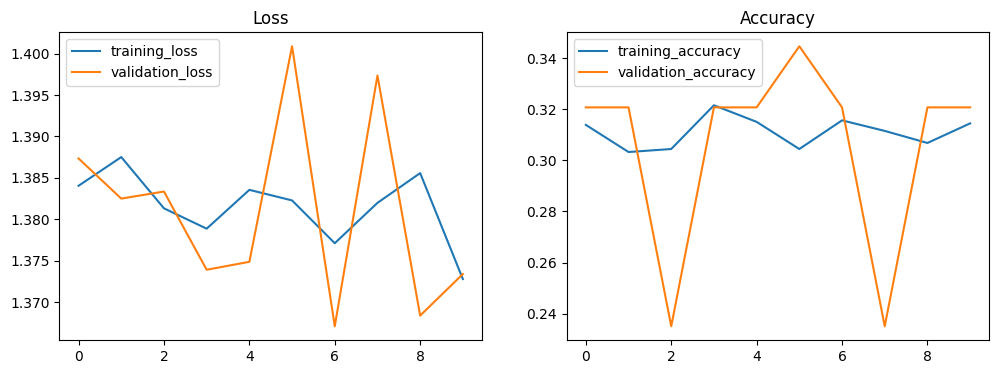

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_eff.history['loss'], label='training_loss')
plt.plot(history_eff.history['val_loss'], label='validation_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history_eff.history['accuracy'], label='training_accuracy')
plt.plot(history_eff.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
test_loss_eff, test_acc_eff, test_precision_eff, test_recall_eff = model_eff.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc_eff:.4f}')
print(f'Test precision: {test_precision_eff:.4f}')
print(f'Test recall: {test_recall_eff:.4f}')
print(f'Test Loss:, {test_loss_eff:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5688 - loss: 1.3008 - precision: 0.0000e+00 - recall: 0.0000e+00

Test accuracy: 0.3252
Test precision: 0.0000
Test recall: 0.0000
Test Loss:, 1.3759


# **Model Comparision**

In [ ]:
result=[]

In [ ]:
# after evaluating

# result.append({'Model': 'CUSTOM MODEL', 'Accuracy': test_acc,
#                  'Precision': test_precision, 'Recall': test_recall})

result.append({'Model': 'VGG16', 'Accuracy': test_acc_vgg,
                 'Precision': test_precision_vgg, 'Recall': test_recall_vgg})

result.append({'Model': 'ResNet50', 'Accuracy': test_acc_resnet,
                 'Precision': test_precision_resnet, 'Recall': test_recall_resnet})

result.append({'Model': 'MobileNetV2', 'Accuracy': test_acc_mob,
                 'Precision': test_precision_mob, 'Recall': test_recall_mob})

result.append({'Model': 'InceptionV3', 'Accuracy': test_acc_inc,
                 'Precision': test_precision_inc, 'Recall': test_recall_inc})

result.append({'Model': 'EfficientNetB0', 'Accuracy': test_acc_eff,
                 'Precision': test_precision_eff, 'Recall': test_recall_eff})


In [ ]:
result

[{'Model': 'VGG16',
  'Accuracy': 0.7601625919342041,
  'Precision': 0.5894308686256409,
  'Recall': 0.895061731338501},
 {'Model': 'ResNet50',
  'Accuracy': 0.7357723712921143,
  'Precision': 0.8232043981552124,
  'Recall': 0.6056910753250122},
 {'Model': 'MobileNetV2',
  'Accuracy': 0.8495935201644897,
  'Precision': 0.8765957355499268,
  'Recall': 0.8373983502388},
 {'Model': 'InceptionV3',
  'Accuracy': 0.8211382031440735,
  'Precision': 0.8597285151481628,
  'Recall': 0.772357702255249},
 {'Model': 'EfficientNetB0',
  'Accuracy': 0.3252032399177551,
  'Precision': 0.0,
  'Recall': 0.0}]

In [ ]:
import pandas as pd
df = pd.DataFrame(result)      # convert list of dicts to DataFrame


In [ ]:
df.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)

In [ ]:

import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/model_comparison.csv')
df

In [ ]:
df

,Model,Accuracy,Precision,Recall
0,VGG16,0.760163,0.589431,0.895062
1,ResNet50,0.735772,0.823204,0.605691
2,MobileNetV2,0.849594,0.876596,0.837398
3,InceptionV3,0.821138,0.859729,0.772358
4,EfficientNetB0,0.325203,0.000000,0.000000


The best performing model is:
Model        MobileNetV2
Accuracy        0.849594
Precision       0.876596
Recall          0.837398
Name: 2, dtype: object


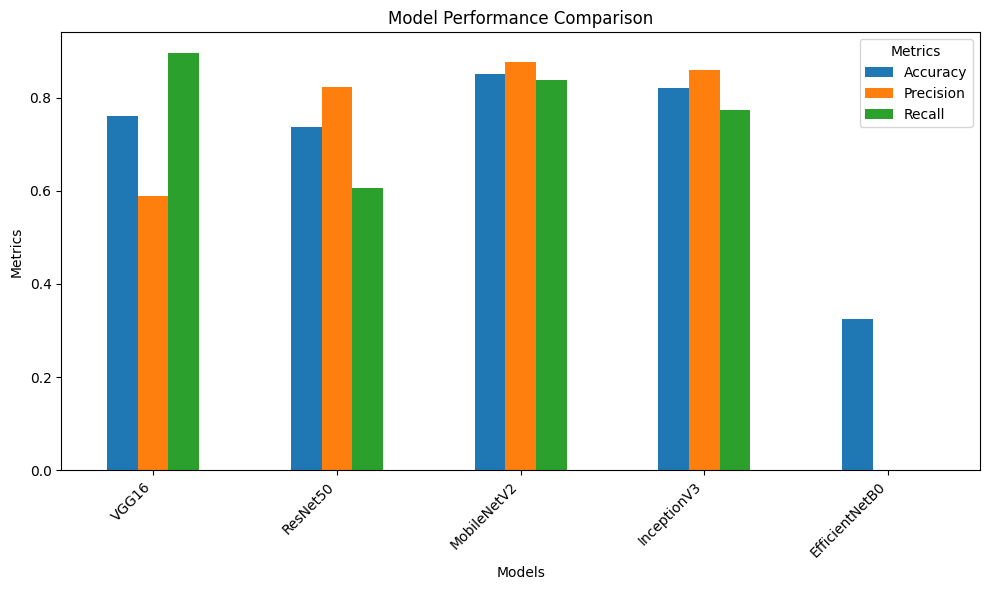

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/model_comparison.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


# **Streamlit**

In [ ]:

!pip install streamlit numpy pillow tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.7 MB/s eta 0:00:00


In [ ]:
%%writefile application.py
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import os
import pandas as pd

st.set_page_config(page_title="Brain Tumour Classifier", layout="wide")

# --- Classes & Model path ---
CLASSES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
MODEL_PATH = "/content/drive/MyDrive/model_mob.h5"  # model path

# --- Dataset summary (as you provided) ---
TRAIN_IMAGES = 564 + 358 + 335 + 438  # = 1695
VALID_IMAGES = 161 + 124 + 99 + 118  # = 502
TEST_IMAGES  = 80 + 63 + 49 + 54      # = 246
TOTAL_IMAGES = TRAIN_IMAGES + VALID_IMAGES + TEST_IMAGES
TOTAL_CLASSES = len(CLASSES)

# --- Example model-comparison data (replace with real numbers) ---
MODEL_COMPARISON = {
    "Model A": 0.91,
    "Model B": 0.93,
    "Model C": 0.89,
}

# --- Sidebar ---
with st.sidebar:
    st.title("🧠 Brain Tumour Detector")
    st.write("Upload an MRI / brain-scan image for tumour classification.")
    st.write("---")
    st.write("**Developed by:** Your Name / Student")
    st.write("---")
    st.write("### Dataset stats")
    st.write(f"- Total images: {TOTAL_IMAGES}")
    st.write(f"- Train images: {TRAIN_IMAGES}")
    st.write(f"- Validation images: {VALID_IMAGES}")
    st.write(f"- Test images: {TEST_IMAGES}")
    st.write(f"- Total classes: {TOTAL_CLASSES}")
    st.write("---")
    st.write("Use the tabs below for Prediction or Summary")

# --- Load model (cached) ---
@st.cache_resource
def load_model(path):
    if os.path.exists(path):
        return tf.keras.models.load_model(path)
    else:
        return None

model = load_model(MODEL_PATH)

# --- Tabs: Prediction & Summary ---
tab1, tab2 = st.tabs(["🔍 Predict Image", "📄 Summary & Model Info"])

with tab1:
    st.header("Upload MRI / Brain-Scan Image")
    if model is None:
        st.error(f"Model not found at `{MODEL_PATH}`")
    else:
        uploaded = st.file_uploader("Choose image (jpg / jpeg / png)", type=["jpg","jpeg","png"])
        if uploaded is not None:
            img = Image.open(uploaded).convert("RGB")
            st.image(img, caption="Uploaded Image", use_column_width=True)
            st.write("---")

            # Preprocess
            img_resized = img.resize((224, 224))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            with st.spinner("Predicting..."):
                preds = model.predict(img_array)[0]

            idx = int(np.argmax(preds))
            pred_class = CLASSES[idx]
            confidence = preds[idx]

            st.subheader("✅ Prediction Result")
            st.markdown(f"**{pred_class}**  —  **Confidence: {confidence*100:.2f}%**")

            st.write("### All class probabilities")
            df_probs = pd.DataFrame({
                "Class": CLASSES,
                "Probability": preds
            }).sort_values(by="Probability", ascending=False).reset_index(drop=True)

            st.bar_chart(df_probs.set_index("Class")["Probability"])
            df_probs["Probability (%)"] = (df_probs["Probability"] * 100).round(2)
            st.table(df_probs[["Class", "Probability (%)"]])

with tab2:
    st.header(" Dataset & Model Summary")

    # Display key metrics as KPI cards
    col1, col2, col3, col4, col5 = st.columns(5)
    col1.metric("Total Images", TOTAL_IMAGES)
    col2.metric("Train Images", TRAIN_IMAGES)
    col3.metric("Val Images", VALID_IMAGES)
    col4.metric("Test Images", TEST_IMAGES)
    col5.metric("Total Classes", TOTAL_CLASSES)

    st.write("")  # blank line
    st.write("---")

    st.subheader("📈 Model Accuracy Comparison")
    df_models = pd.DataFrame.from_dict(MODEL_COMPARISON, orient="index", columns=["Accuracy"])
    df_models["Accuracy (%)"] = (df_models["Accuracy"] * 100).round(2)

    st.dataframe(df_models)

    st.bar_chart(df_models["Accuracy (%)"])




Overwriting application.py


In [ ]:
Cloudfare

Cloudfare

In [ ]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2025-12-06 08:14:56--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2025-12-06 08:14:56--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-06T09%3A07%3A25Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-06

In [ ]:
!streamlit run /content/application.py &>/content/logs.txt &

In [ ]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://acquire-worm-established-rings.trycloudflare.com
